# Interpreting BERT Models (Part 1)

In this notebook we demonstrate how to interpret Bert models using  `Captum` library. In this particular case study we focus on a fine-tuned Question Answering model on SQUAD dataset using transformers library from Hugging Face: https://huggingface.co/transformers/

We show how to use interpretation hooks to examine and better understand embeddings, sub-embeddings, bert, and attention layers. 

Note: Before running this tutorial, please install `seaborn`, `pandas` and `matplotlib`, `transformers`(from hugging face) python packages.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The first step is to fine-tune BERT model on SQUAD dataset. This can be easiy accomplished by following the steps described in hugging face's official web site: https://github.com/huggingface/transformers#run_squadpy-fine-tuning-on-squad-for-question-answering 

After we pretrain the model, we can load the tokenizer and pre-trained BERT model using the commands described below. 

In [3]:
# replace <PATH-TO-SAVED-MODEL> with the real path of the saved model
model_path = '<PATH-TO-SAVED-MODEL>'

# load model
model = BertForQuestionAnswering.from_pretrained(model_path)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

A helper function to perform forward pass of the model and make predictions.

In [4]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    return model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )

Defining a custom forward function that will allow us to access the start and end postitions of our prediction using `position` input argument.

In [5]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

Let's compute attributions with respect to the `BertEmbeddings` layer.

To do so, we need to define baselines / references, numericalize both the baselines and the inputs. We will define helper functions to achieve that.

The cell below defines numericalized special tokens that will be later used for constructing inputs and corresponding baselines/references.

In [6]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

Below we define a set of helper function for constructing references / baselines for word tokens, token types and position ids. We also provide separate helper functions that allow to construct the sub-embeddings and corresponding baselines / references for all sub-embeddings of `BertEmbeddings` layer.

In [7]:
def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_bert_sub_embedding(input_ids, ref_input_ids,
                                   token_type_ids, ref_token_type_ids,
                                   position_ids, ref_position_ids):
    input_embeddings = interpretable_embedding1.indices_to_embeddings(input_ids)
    ref_input_embeddings = interpretable_embedding1.indices_to_embeddings(ref_input_ids)

    input_embeddings_token_type = interpretable_embedding2.indices_to_embeddings(token_type_ids)
    ref_input_embeddings_token_type = interpretable_embedding2.indices_to_embeddings(ref_token_type_ids)

    input_embeddings_position_ids = interpretable_embedding3.indices_to_embeddings(position_ids)
    ref_input_embeddings_position_ids = interpretable_embedding3.indices_to_embeddings(ref_position_ids)
    
    return (input_embeddings, ref_input_embeddings), \
           (input_embeddings_token_type, ref_input_embeddings_token_type), \
           (input_embeddings_position_ids, ref_input_embeddings_position_ids)
    
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    
    return input_embeddings, ref_input_embeddings


Let's define the `question - text` pair that we'd like to use as an input for our Bert model and interpret what the model was forcusing on when predicting an answer to the question from given input text 

In [8]:
question, text = "What is important to us?", "It is important to us to include, empower and support humans of all kinds."

Let's numericalize the question, the input text and generate corresponding baselines / references for all three sub-embeddings (word, token type and position embeddings) types using our helper functions defined above.

In [9]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

Also, let's define the ground truth for prediction's start and end positions.

In [10]:
ground_truth = 'to include, empower and support humans of all kinds'

ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

Now let's make predictions using input, token type, position id and a default attention mask.

In [11]:
start_scores, end_scores = predict(input_ids, \
                                   token_type_ids=token_type_ids, \
                                   position_ids=position_ids, \
                                   attention_mask=attention_mask)


print('Question: ', question)
print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))

Question:  What is important to us?
Predicted Answer:  to include , em ##power and support humans of all kinds


There are two different ways of computing the attributions for `BertEmbeddings` layer. One option is to use `LayerIntegratedGradients` and compute the attributions with respect to that layer. The second option is to pre-compute the embeddings and wrap the actual embeddings with `InterpretableEmbeddingBase`. The pre-computation of embeddings for the second option is necessary because integrated gradients scales the inputs and that won't be meaningful on the level of word / token indices.

Since using `LayerIntegratedGradients` is simpler, let's use it here.

In [12]:
lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                  return_convergence_delta=True)
attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                additional_forward_args=(token_type_ids, position_ids, attention_mask, 1),
                                return_convergence_delta=True)

A helper function to summarize attributions for each word token in the sequence.

In [13]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [14]:
attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)

In [15]:
# storing couple samples in an array for visualization purposes
start_position_vis = viz.VisualizationDataRecord(
                        attributions_start_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        torch.argmax(start_scores),
                        str(ground_truth_start_ind),
                        attributions_start_sum.sum(),       
                        all_tokens,
                        delta_start)

end_position_vis = viz.VisualizationDataRecord(
                        attributions_end_sum,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        torch.argmax(end_scores),
                        str(ground_truth_end_ind),
                        attributions_end_sum.sum(),       
                        all_tokens,
                        delta_end)

print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([start_position_vis])

print('\033[1m', 'Visualizations For End Position', '\033[0m')
viz.visualize_text([end_position_vis])

 Visualizations For Start Position 


 Visualizations For End Position 


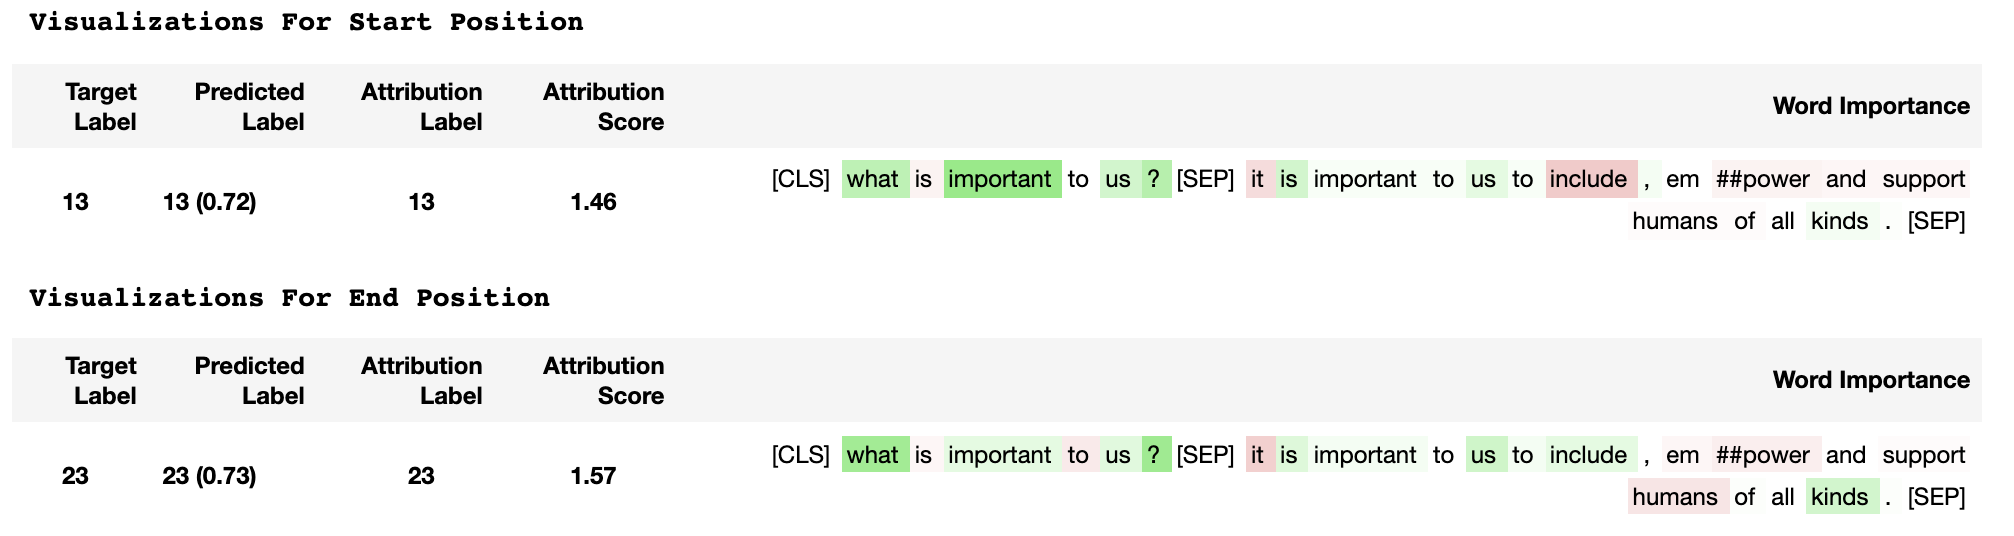

In [16]:
from IPython.display import Image
Image(filename='img/bert/visuals_of_start_end_predictions.png')

From the results above we can tell that for predicting start position our model is focusing more on the question side. More specifically on the tokens `what` and `important`. It has also slight focus on the token sequence `to us to` in the text side.

In contrary to that, for predicting end position, our model focuses more on the text side and has relative high attribution on the last end position token `kinds`.

# Multi-Embedding attribution

Now let's look into the sub-embeddings of `BerEmbeddings` and try to understand the contributions and roles of each of them for both start and end predicted positions.

To do so, we'd need to place interpretation hooks in each three of them.

Note that we could perform attribution by using `LayerIntegratedGradients` as well but in that case we have to call attribute three times for each sub-layer since currently `LayerIntegratedGradients` takes only a layer at a time. In the future we plan to support multi-layer attribution and will be able to perform attribution by only calling attribute once. 

`configure_interpretable_embedding_layer` function will help us to place interpretation hooks on each sub-layer. It returns `InterpretableEmbeddingBase` layer for each sub-embedding and can be used to access the embedding vectors. 

Note that we need to remove InterpretableEmbeddingBase wrapper from our model using remove_interpretable_embedding_layer function after we finish interpretation.


In [ ]:
interpretable_embedding1 = configure_interpretable_embedding_layer(model, 'bert.embeddings.word_embeddings')
interpretable_embedding2 = configure_interpretable_embedding_layer(model, 'bert.embeddings.token_type_embeddings')
interpretable_embedding3 = configure_interpretable_embedding_layer(model, 'bert.embeddings.position_embeddings')

`BertEmbeddings` has three sub-embeddings, namely, `word_embeddings`, `token_type_embeddings` and `position_embeddings` and this time we would like to attribute to each of them independently.
`construct_bert_sub_embedding` helper function helps us to construct input embeddings and corresponding references in a separation.

In [18]:
(input_embed, ref_input_embed), (token_type_ids_embed, ref_token_type_ids_embed), (position_ids_embed, ref_position_ids_embed) = construct_bert_sub_embedding(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

Now let's create an instance of `IntegratedGradients` and compute the attributions with respect to all those embeddings both for the start and end positions and summarize them for each word token.

In [19]:
ig = IntegratedGradients(squad_pos_forward_func)

attributions_start = ig.attribute(inputs=(input_embed, token_type_ids_embed, position_ids_embed),
                                  baselines=(ref_input_embed, ref_token_type_ids_embed, ref_position_ids_embed),
                                  additional_forward_args=(attention_mask, 0))
attributions_end = ig.attribute(inputs=(input_embed, token_type_ids_embed, position_ids_embed),
                                  baselines=(ref_input_embed, ref_token_type_ids_embed, ref_position_ids_embed),
                                  additional_forward_args=(attention_mask, 1))

attributions_start_word = summarize_attributions(attributions_start[0])
attributions_end_word = summarize_attributions(attributions_end[0])

attributions_start_token_type = summarize_attributions(attributions_start[1])
attributions_end_token_type = summarize_attributions(attributions_end[1])

attributions_start_position = summarize_attributions(attributions_start[2])
attributions_end_position = summarize_attributions(attributions_end[2])


An auxilary function that will help us to compute topk attributions and corresponding indices

In [20]:
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

Removing interpretation hooks from all layers after finishing attribution.

In [21]:
remove_interpretable_embedding_layer(model, interpretable_embedding1)
remove_interpretable_embedding_layer(model, interpretable_embedding2)
remove_interpretable_embedding_layer(model, interpretable_embedding3)

Computing topk attributions for all sub-embeddings and placing them in pandas dataframes for better visualization.

In [22]:
top_words_start, top_words_val_start, top_word_ind_start = get_topk_attributed_tokens(attributions_start_word)
top_words_end, top_words_val_end, top_words_ind_end = get_topk_attributed_tokens(attributions_end_word)

top_token_type_start, top_token_type_val_start, top_token_type_ind_start = get_topk_attributed_tokens(attributions_start_token_type)
top_token_type_end, top_token_type_val_end, top_token_type_ind_end = get_topk_attributed_tokens(attributions_end_token_type)

top_pos_start, top_pos_val_start, pos_ind_start = get_topk_attributed_tokens(attributions_start_position)
top_pos_end, top_pos_val_end, pos_ind_end = get_topk_attributed_tokens(attributions_end_position)

df_start = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_start, top_word_ind_start, top_words_val_start)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_start, top_token_type_ind_start, top_words_val_start)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_start, pos_ind_start, top_pos_val_start)]})
df_start.style.apply(['cell_ids: False'])

df_end = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_end, top_words_ind_end, top_words_val_end)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_end, top_token_type_ind_end, top_words_val_end)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_end, pos_ind_end, top_pos_val_end)]})
df_end.style.apply(['cell_ids: False'])

['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

['[CLS](0)',
 'what(1)',
 'is(2)',
 'important(3)',
 'to(4)',
 'us(5)',
 '?(6)',
 '[SEP](7)',
 'it(8)',
 'is(9)',
 'important(10)',
 'to(11)',
 'us(12)',
 'to(13)',
 'include(14)',
 ',(15)',
 'em(16)',
 '##power(17)',
 'and(18)',
 'support(19)',
 'humans(20)',
 'of(21)',
 'all(22)',
 'kinds(23)',
 '.(24)',
 '[SEP](25)']

Below we can see top 5 attribution results from all three embedding types in predicting start positions.

Word embeddings help to focus more on the the start position answer `to` and its surrounding tokens. It also has relatively high attribution for the tokens in the question such as `it` and `important`.

In contrary to word embedding, token embedding type focuses more on the tokens in the text part such as `include`,`em` and `and`.

Position embedding also has high attribution for correctly predicted start token `to`, including some other tokens in the answer such as `humans` and `##power`.


#### Top 5 attributed embeddings for start position

In [23]:
df_start

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"it (8), 0.41",", (15), 0.41","##power (17), 0.5"
1,", (15), 0.4","of (21), 0.4","it (8), 0.32"
2,"important (3), 0.35","include (14), 0.35","humans (20), 0.26"
3,"to (13), 0.29","em (16), 0.29","us (12), 0.26"
4,"us (5), 0.23","and (18), 0.23","to (13), 0.22"


We can perform similar analysis, and visualize top 5 attributed tokens for all three embedding types, also for the end position prediction.

It is interesting to observe high concentration of highly attributed tokens such as `.`, `of`, `kinds`, `humans` and `[SEP]` for end position prediction.

The token `kinds`, which is the correct predicted token appears to have high attribution score both according word and position embeddings.


#### Top 5 attributed embeddings for end position

In [24]:
df_end

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"kinds (23), 0.49","and (18), 0.49","kinds (23), 0.85"
1,", (15), 0.34","[SEP] (25), 0.34","humans (20), 0.23"
2,"it (8), 0.33","[SEP] (7), 0.33",". (24), 0.17"
3,"of (21), 0.29","of (21), 0.29","to (4), 0.17"
4,"? (6), 0.25",", (15), 0.25","of (21), 0.14"


# Interpreting Bert Layers

Now let's look into the layers of our network. More specifically we would like to look into the distribution of attribution scores for each token across all layers in Bert model and dive deeper into specific tokens.  
We do that using one of layer attribution algorithms, namely, layer conductance. However, we encourage you to try out and compare the results with other algorithms as well.


Let's configure `InterpretableEmbeddingsBase` again, in this case in order to interpret the layers of our model.

In [ ]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'bert.embeddings')

Let's iterate over all layers and compute the attributions for all tokens. In addition to that let's also choose a specific token that we would like to examine in detail, specified by an id `token_to_explain` and store related information in a separate array.


Note: Since below code is iterating over all layers it can take over 10 seconds. Please be patient!

In [26]:
layer_attrs_start = []
layer_attrs_end = []

# The token that we would like to examine separately.
token_to_explain = 23 # the index od the token
layer_attrs_start_dist = []
layer_attrs_end_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids,attention_mask, 0))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids,attention_mask, 1))

    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_start_dist.append(layer_attributions_start[0,token_to_explain,:].cpu().detach().tolist())
    layer_attrs_end_dist.append(layer_attributions_end[0,token_to_explain,:].cpu().detach().tolist())


The plot below represents a heat map of attributions across all layers and tokens for the start position prediction. 
It is interesting to observe that the question word `what` gains increasingly high attribution from layer one to ten. In the last two layers that importance is slowly diminishing.  
In contrary to `what` token `it` has negative and zero attribution in the first 10 layers. However, surprisingly, last two layers assign higher attribution score to it.

And lastly, our correctly predicted token `to` for the start position gains increasingly positive attribution starting from layer seven.


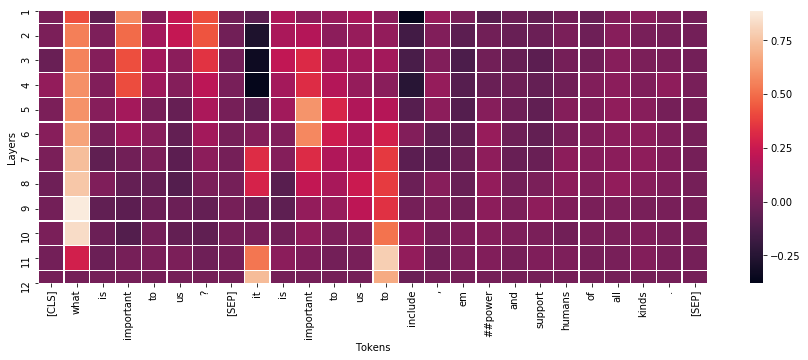

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

Now let's examine the heat map of the attributions for the end position prediction. In the case of end position prediction we again observe high attribution scores for the token `what` in the last 11 layers.
The token `it` seems to be harming the prediction the most. It's even more noticeable for the end position prediction than for the start. The correctly predicted end token `kinds` has positive attribution across all layers and it is especially prominent in the last two layers.

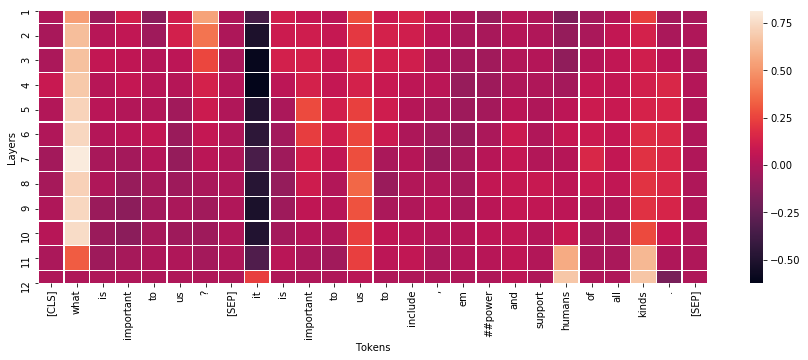

In [28]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_end), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

It is interesting to note that when we compare the heat maps of start and end position, overall the colors for start position prediction on the map have darker intensities. This implies that there are less tokens that attribute positively to the start position prediction and there are more tokens which are negative indicators or signals of start position prediction.

Now let's dig deeper into specific tokens and look into the distribution of attributions per layer for the token `kinds` in the start and end positions. The box plot diagram below shows the presence of outliers especially in the first four layers and in layer 8. We also observe that for start position prediction interquartile range slowly decreases as we go deeper into the layers and finally it is dimishing.



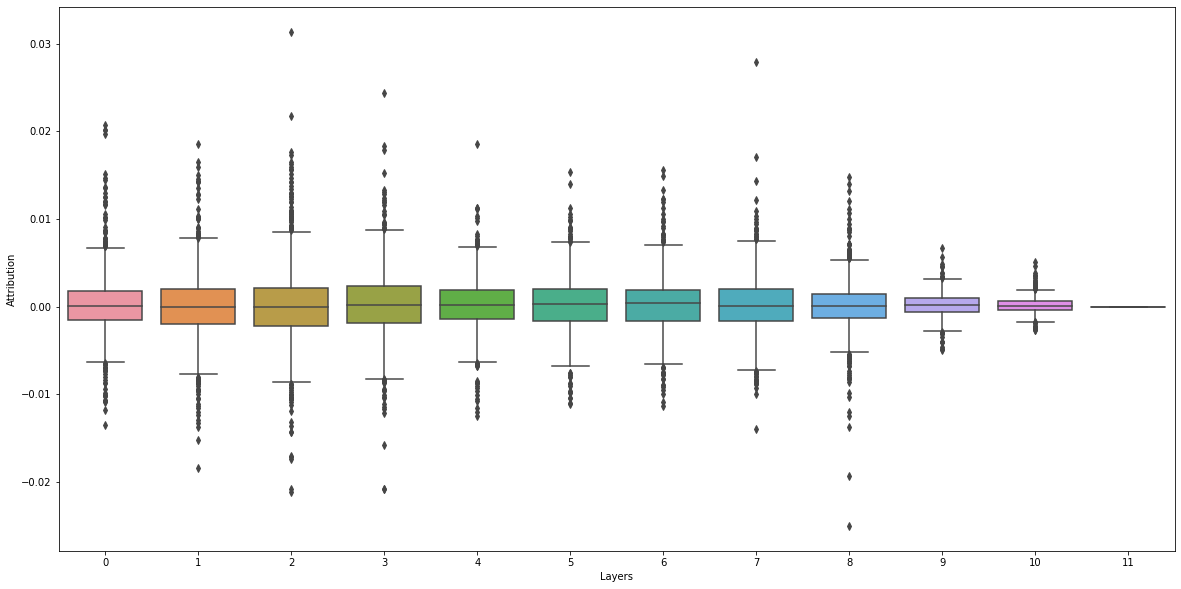

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_start_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

Now let's plot same distribution but for the prediction of the end position. Here attribution has larger positive values across all layers and the interquartile range doesn't change much when moving deeper into the layers.

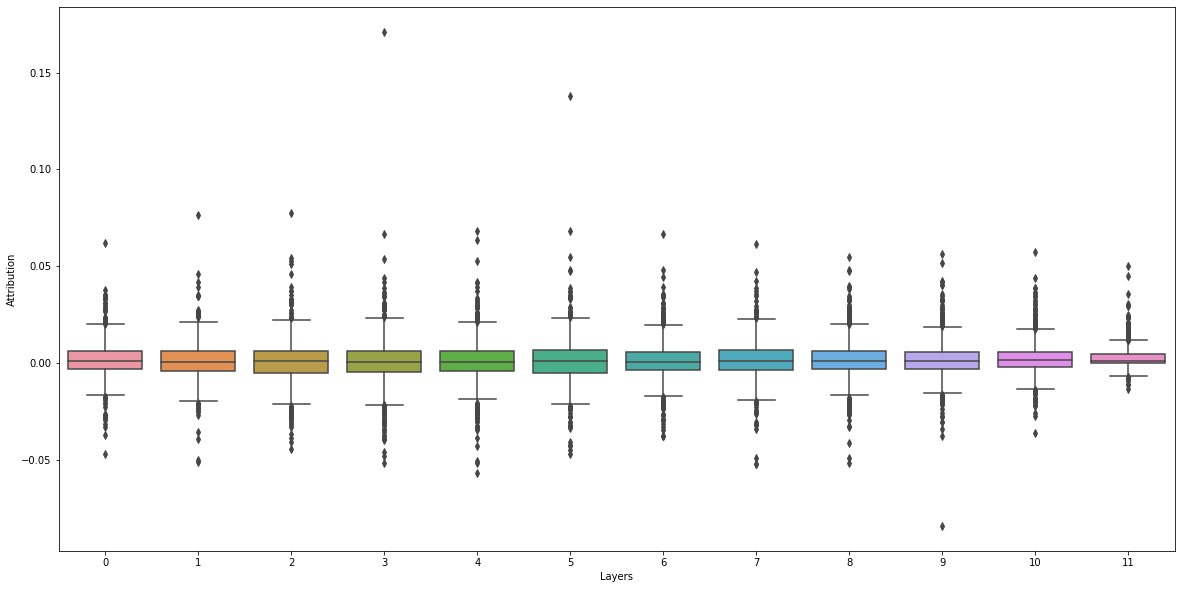

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_end_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

Now, let's remove interpretation hooks, since we finished interpretation at this point

In [31]:
remove_interpretable_embedding_layer(model, interpretable_embedding)

An addition to this we can also represent attributions as a probability density function and compute the entropy of it in order to estimate the uncertainties of attributions.

TODO add entropy diagram here


In the Part 2 of this tutorial we will to go deeper into attention layers, heads and compare the attributions with the attention weight matrices and study and discuss related statistics.